###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.

# Riding the wave

## Convection problems

Welcome to *Riding the wave: Convection problems*, the third module of  ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about). 

In the [first module](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/01_phugoid), we learned about numerical integration methods for the solution of ordinary differential equations (ODEs). The [second module](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/02_spacetime) introduced the finite difference method for numerical solution of partial differential equations (PDEs), where we need to discretize both *space* and *time*.

This module explores the convection equation in more depth, applied to a traffic-flow problem.  We already introduced convection in [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb). This hyperbolic equation is very interesting because the solution can develop *shocks*, or regions with very high gradient, which are difficult to resolve well with numerical methods. 

We will start by introducing the concept of a conservation law, closely related to the convection equation.  Then we'll explore different numerical schemes and how they perform when shocks are present. 

## Conservation laws

You know from (non relativistic) physics that mass is _conserved_. This is one example of a conserved quantity, but there are others (like momentum and energy) and they all obey a _conservation law_. Let's start with the more intuitive case of conservation of mass.

### Conservation of mass

In any closed system, we know that the mass $M$ in the system does not change, which we can write: $\frac{D\,M}{Dt} =0$. When we change the point of view from a closed system to what engineers call a _control volume_, mass can move in and out of the volume and conservation of mass is now expressed by:

![massconservation-CV](./figures/massconservation-CV.png)

Let's imagine the control volume as a tiny cylinder of cross-section dA and length dx, like in the sketch below.

![1Dcontrolvolume](./figures/1Dcontrolvolume.png)
#### Figure 1. Tiny control volume in the shape of a cylinder.

If we represent the mass density by $\rho$, then mass is equal to $\rho\times$ volume. For simplicity, let's assume that mass flows in or out of the control volume only in one direction, say, the $x$-direction. Express the 1D velocity component by $u$, and conservation of mass for the control volume is translated to a mathematical expression as follows:

\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}\rho \, dV + \int_{\text{cs}}\rho \, u\, dA =0
\end{equation}

where "cv" stands for control volume and "cs" stands for control surface. The first term represents the rate of change of mass in the control volume, and the second term is the rate of flow of mass, with velocity $u$, accross the control surface.



Since the control volume is very small, we can take, to leading order, $\rho$ as a uniform quantity inside it, and the first term in equation (1) can be simplified to the time derivative of density multiplied by the volume of the tiny cylinder, $dAdx$:

$$\frac{\partial}{\partial t}\int_{\text{cv}}\rho \, dV \rightarrow \frac{\partial \rho}{\partial t} dAdx$$

Now, for the second term in equation (1), we have to do a little more work. The quantity inside the integral is now $\rho u$ and, to leading order, we have to take into consideration that this quantity can change in the distance $dx$. Take $\rho u$ to be the value in the center of the cylinder. Then the flow of mass on each side is illustrated in the figure below, where we use a Taylor expansion of the quantity $\rho u$ around the center of the control volume (to first order).

![1Dfluxbalance](./figures/1Dfluxbalance.png)
#### Figure 2. Flux terms on the control surfaces.

Subtracting the negative flux on the left to the positive flux on the right, we arrive at the total flux of mass accross the control surfaces, the second term in equation (1):

$$ \int_{\text{cs}}\rho \, u\, dA \rightarrow \frac{\partial}{\partial x}(\rho u) dAdx$$

We can now put together the equation of conservation of mass for the tiny cylindrical control volume, which after diving by $dAdx$ is:

\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho u)=0
\end{equation}

This is the 1D mass conservation equation in differential form. If we take $u$ to be a constant and take it out of the spatial derivative this equation looks the same as the first PDE we studied: the linear convection equation in [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb).
But in the form shown above, it is a typical _conservation law_. The term under the spatial derivative is called the _flux_, for reasons that should be clear from our discussion above: it represents amounts of the conserved quantity flowing across the boundary of the control volume.

##### Dig deeper

You can follow the derivation of the full three-dimensional equation of conservation of mass for a flow on this screencast by Prof. Barba (duration 12:47).

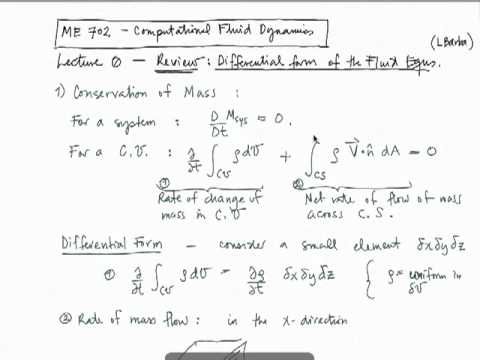

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('35unQgSaT88')

### General conservation laws

All conservation laws express the same idea: the variation of a conserved quantity inside a control volume is due to the total flux of that quantity crossing the boundary surface (plus possibly the effect of any sources inside the volume, but let's ignore those for now).

The _flux_ is a fundamental concept in conservation laws: it represents the amount of the quantity that crosses a surface per unit time. Our discussion above was limited to flow in one dimension, but in general the flux has any direction and is a vector quantity. Think about this: if the direction of flow is parallel to the surface, then no quantity comes in or out. We really only care about the component of flux perpendicular to the surface. Mathematically, for a vector flux $\vec{F}$, the amount of the conserved quantity crossing a small surface element is:

$$\vec{F}\cdot d\vec{A}$$

where $d\vec{A}$ points in the direction of the outward normal to the surface. A general conservation law for a quantity $e$ is thus (still ignoring possible sources):

\begin{equation}
\frac{\partial}{\partial t}\int_{\text{cv}}e \, dV + \oint_{\text{cs}}\vec{F}\cdot d\vec{A} =0
\end{equation}

To obtain a differential form of this conservation equation, we can apply the theorem of Gauss to the second integral, which brings the gradient of $\vec{F}$ into play. One way to recognize a conservation law in differential form is that the _fluxes appear only under the gradient operator_.

Recall the non-linear convection equation from [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb). It was:

\begin{equation}\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0\end{equation}

If we look closely at the spatial derivative, we can rewrite this equation as

\begin{equation}\frac{\partial u}{\partial t} + \frac{\partial}{\partial x} \left(\frac{u^2}{2} \right) = 0, \end{equation}

which is the *conservation form* of the non-linear convection equation, with flux $F=\frac{u^2}{2}$.

## Traffic flow model

We've all experienced it: as rush hour approaches certain roads in or out of city centers start getting full of cars, and the speed of travel can reduce to a crawl. Sometimes, the cars stop altogether. If you're a driver, you know that the more cars on the road, the slower your trip will flow.

Traffic flow models seek to describe these everyday experiences with mathematics, to help engineers design better road systems.

Let's review the [Lighthill-Whitham-Richards](http://en.wikipedia.org/wiki/Macroscopic_traffic_flow_model) traffic model that was offered as an exercise at the end of Module 2. This model considers cars with a continuous *traffic density* (average number of cars per unit length of road) rather than keeping track of them individually. If $\rho(x)=0$, there are no cars at that point $x$ of the road.  If $\rho(x) = \rho_{\rm max}$, traffic is literally bumper to bumper.

If the number of cars on a bounded stretch of road changes, it means that cars are entering or leaving the road somehow. _Traffic density obeys a conservation law_ (!) where the flux is the number of cars leaving the road per unit time. It is given by $F=\rho u$—as with mass conservation, flux equals density times velocity. But don't forget your experience on the road: the speed of travel depends on the car density. Here, $u$ refers not to the speed of each individual car, but to the _traffic speed_ at a given point of the road.  

You know from experience that with more cars on the road, the speed of travel decreases. It is also true that if you are traveling at fast speed, you are advised to leave a larger gap with cars ahead. These two considerations lead us to propose a monotonically decreasing $u=u(\rho)$ function. As a first approximation, we may consider the linear function:

\begin{equation}u(\rho) = u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)\end{equation}

![velocityvsdensity](./figures/velocityvsdensity.png)
#### Figure 3. Traffic speed vs. traffic density.

The linear model of the behavior of drivers satisfies these experimental observations:  
1.  All drivers will approach a maximum velocity $u_{max}$ when the road is empty.
2.  If the road is completely jampacked ($\rho \rightarrow \rho_{max}$), velocity goes to zero.  

That seems like a reasonable approximation of reality! 

Applying a conservation law to the vehicle traffic, the traffic density will obey the following transport equation:

\begin{equation} \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0 \end{equation}

where $F$ is the *traffic flux*, which in the linear traffic-speed model is given by: 

\begin{equation} F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right).
\end{equation}

We can now use our numerical kung-fu to solve some interesting traffic situations, and check if our simple model gives realistic results!

### Green light!

Let's say that we are examining a road of length $4$ where the speed limit is $u_{\rm max}=1$, fitting $10$ cars per unit length $(\rho_{\rm max}=10)$. Now, imagine we have an intersection with a red light at $x=2$.  At the stoplight, traffic is bumper-to-bumper, and the traffic density decreases linearly to zero as we approach the beginning of our road. Ahead of the stoplight, the road is clear.

Mathematically, we can represent this situation with the following initial condition:

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
\rho_{\rm max}\frac{x}{2} & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\ \end{array} \right.\end{equation}

Let's see what a plot of that looks like.

In [1]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def rho_green_light(nx, rho_light):
    """Computes "green light" initial condition with shock, and linear distribution behind

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_light : float
        Density of cars at stoplight

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """    
    rho = numpy.arange(nx)*2./nx*rho_light  # Before stoplight
    #rho = numpy.arange(nx)*2.5 / nx
    rho[int((nx-1)/2):] = 0
    
    return rho

In [3]:
#Basic initial condition parameters
#defining grid size, time steps
nx = 81
nt = 30
dx = 4.0/(nx-1)


x = numpy.linspace(0,4,nx)

rho_max = 10.
u_max = 1.
rho_light = 10.

rho = rho_green_light(nx, rho_light)
rho

array([ 0.        ,  0.24691358,  0.49382716,  0.74074074,  0.98765432,
        1.2345679 ,  1.48148148,  1.72839506,  1.97530864,  2.22222222,
        2.4691358 ,  2.71604938,  2.96296296,  3.20987654,  3.45679012,
        3.7037037 ,  3.95061728,  4.19753086,  4.44444444,  4.69135802,
        4.9382716 ,  5.18518519,  5.43209877,  5.67901235,  5.92592593,
        6.17283951,  6.41975309,  6.66666667,  6.91358025,  7.16049383,
        7.40740741,  7.65432099,  7.90123457,  8.14814815,  8.39506173,
        8.64197531,  8.88888889,  9.13580247,  9.38271605,  9.62962963,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

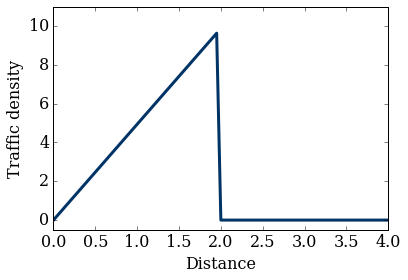

In [4]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

**How does the traffic behave once the light turns green?** Cars should slowly start moving forward: the density profile should move to the right. Let's see if the numerical solution agrees with that!

Before we start, let's define a function to calculate the traffic flux. We'll use it in each time step of our numerical solution.

In [5]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho

    Parameters
    ----------
    u_max  : float
        Maximum allowed velocity
    rho    : array of floats
        Array with density of cars at every point x
    rho_max: float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

### Forward-time/backward-space

Start by using a forward-time, backward-space scheme, like you used in Module 2. The discretized form of our traffic model is:

\begin{equation}
\frac{\rho^{n+1}_i- \rho^n_{i}}{\Delta t}+ \frac{F^n_{i}-F^n_{i-1}}{\Delta x}=0
\end{equation}

Like before, we'll step in time via a for-loop, and we'll operate on all spatial points simultaneously via array operations. In each time step, we also need to call the function that computes the flux. Here is a function that implements in code the forward-time/backward-space difference scheme:

In [6]:
def ftbs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with forward in time, backward in space
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[0,:] = rho.copy()              
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:] = rho[1:] - dt/dx*(F[1:]-F[:-1])
        rho_n[t,0] = rho[0]
        rho = rho_n[t].copy()

    return rho_n

We're all good to go! 

**Note:** The code above saves the complete traffic density at each time-step—we'll use that in a second to create animations with our results.  

Running the numerical solution is easy now: we just need to call the function for evolving the initial condition with the forward-time/backward-space scheme.

In [7]:
sigma = 1.
dt = sigma*dx

rho_n = ftbs(rho, nt, dt, dx, rho_max, u_max)
rho_n[-1,:]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.83947649e-09,   5.00308819e+16,
         1.03619818e+25,   1.57609884e+27,   5.75338964e+27,
         9.69186407e+27,   1.40751310e+28,   1.81456695e+28,
         2.21024898e+28,   2.70702728e+28,   3.55817214e+28,
        -4.01708202e+28,   6.43015539e+29,   1.87711546e+29,
         1.00978912e+31,   1.64200459e+34,   1.73647887e+44,
        -1.73031038e+44,   1.17633109e+47,  -1.61775994e+46,
         3.52673178e+47,  -4.54129305e+47,  -2.24349816e+36,
         4.43366550e+39,   5.84633736e+44,  -5.74774312e+44,
         1.26515813e+50,

Let's see how that looks. In order to view the results in an animation, we'll import a few extra libraries.  The `JSAnimation` library is not part of the standard IPython install (yet!) but hopefully you installed it for [Lesson 3 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_03_1DDiffusion.ipynb). Either way, if you need to install it, [follow our handy instructions](https://github.com/numerical-mooc/numerical-mooc/wiki/HOWTO:-Install-JSAnimation-for-IPython-Notebook).

You've had some experience already using `JSAnimation`—in  [Lesson 3 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_03_1DDiffusion.ipynb) we created `animate` functions that performed two roles: they both calculated the results of our computation and also animated them.  

Below is another way to use `JSAnimation`.  Instead of computing and animating at the same time, we can pass the results of our calculation, stored in the array `rho_n`, as individual frames.  

It doesn't make much of a difference for a computationally light example like this one, but if you want to animate more complicated problems, it's nice to separate the computation from the visualization.  You don't want to re-run your entire simulation just so you can update the line style!

In [8]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation


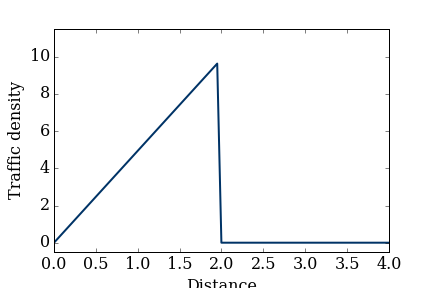
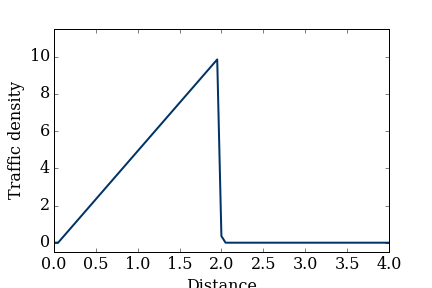
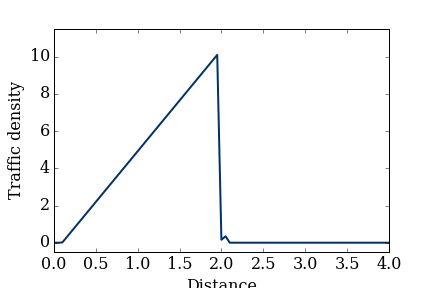
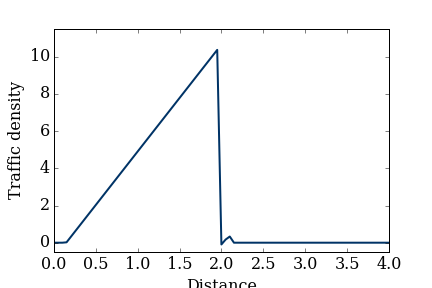
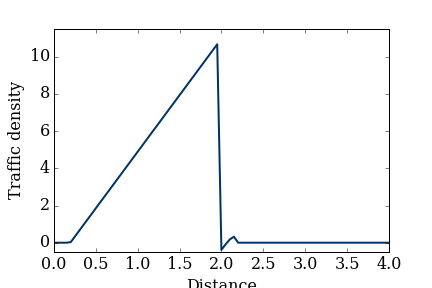
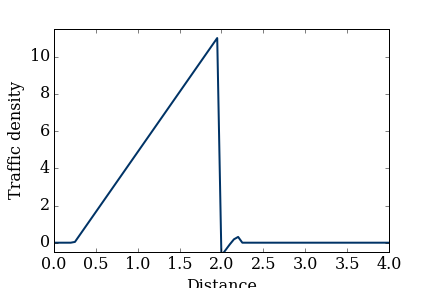
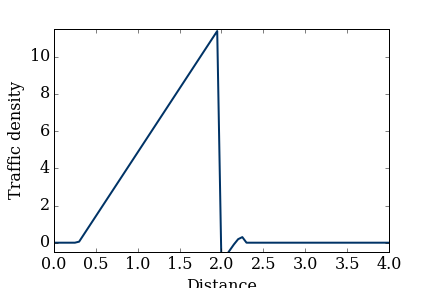
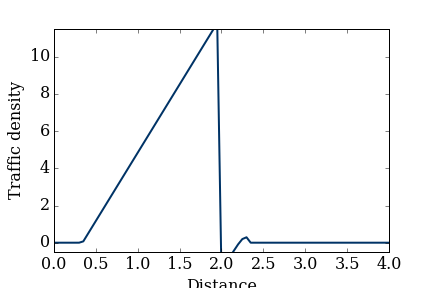
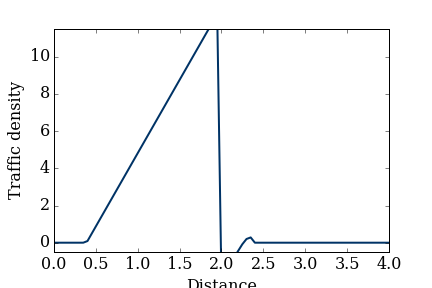
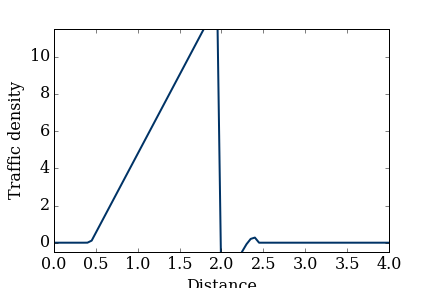
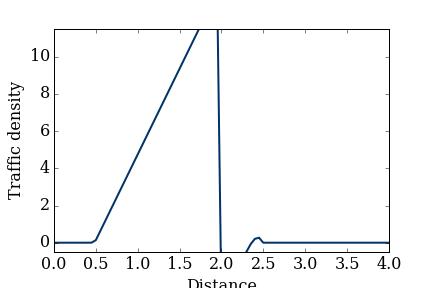
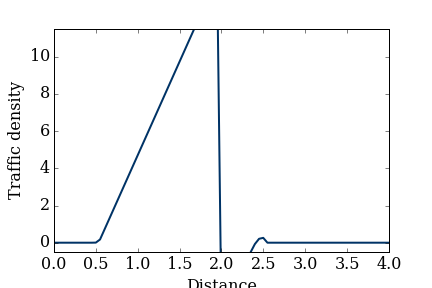
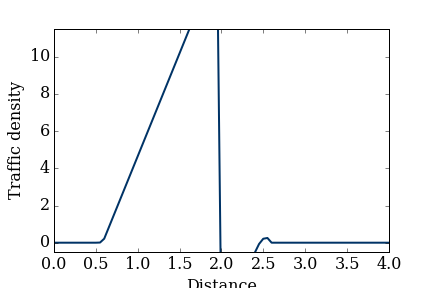
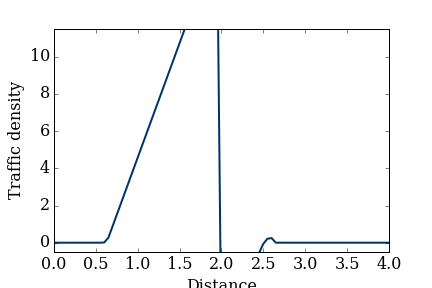
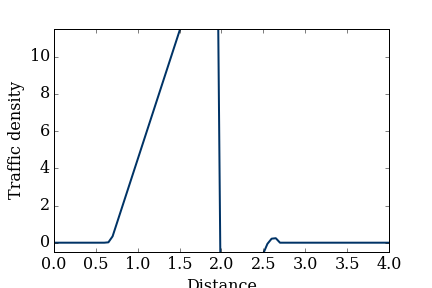
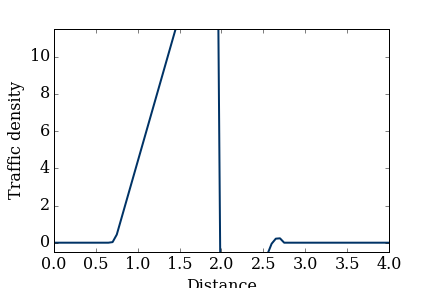
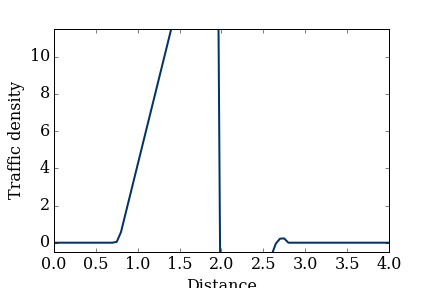
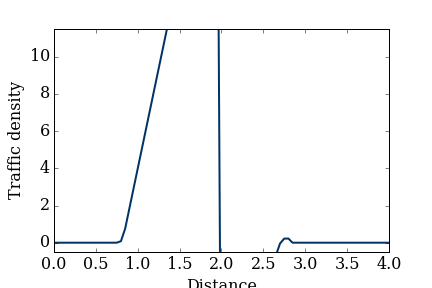
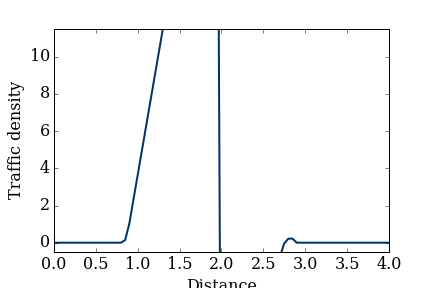
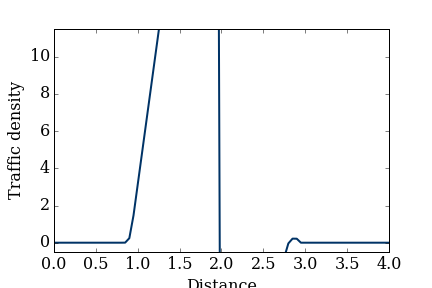
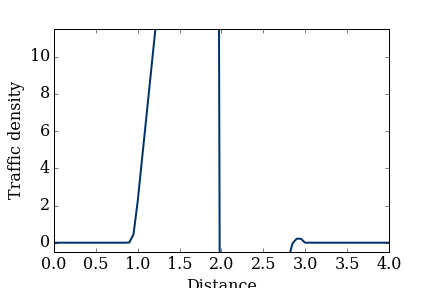
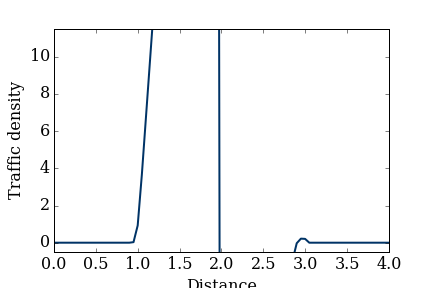
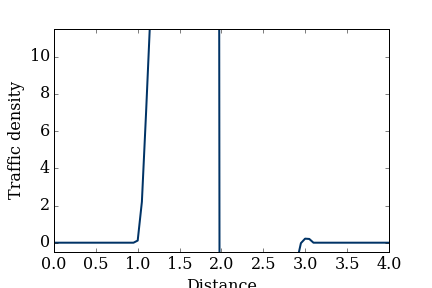
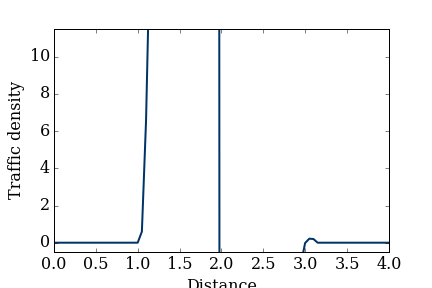
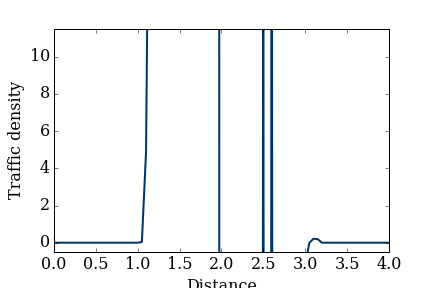
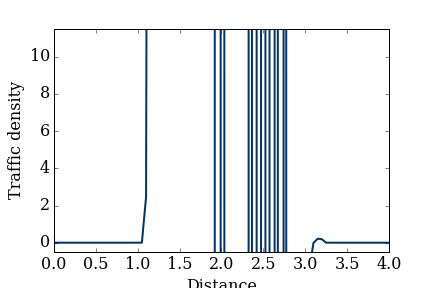
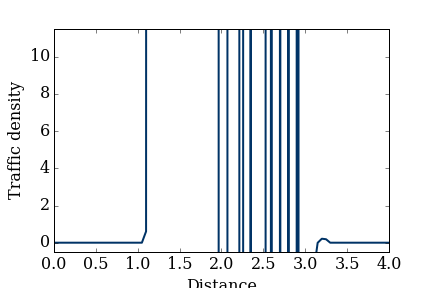
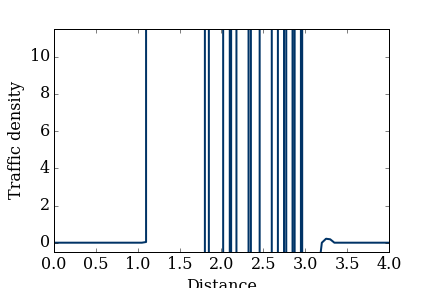
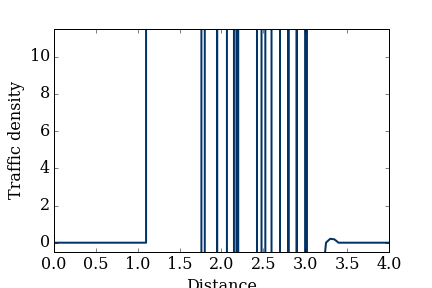
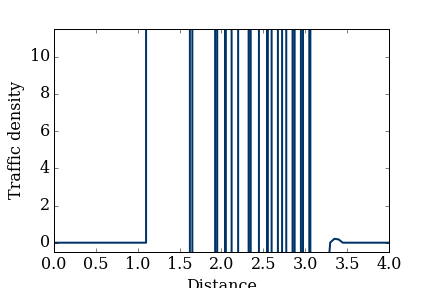

In [9]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(-.5,11.5),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

**Yikes! The solution is blowing up.** This didn't happen in your traffic-flow exercise (coding assignment) for Module 2! (Thankfully.) What is going on? Is there a bug in the code?

No need to panic. Let's take a closer look at the equation we are solving:

\begin{equation}\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0\end{equation}

Using the chain rule of calculus, rewrite is as follows:

\begin{equation} \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0\end{equation}

This form of the equation looks like the nonlinear convection equation from [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb), right? This is a wave equation where the wave speed is $u_{\rm wave} = \frac{\partial F}{\partial\rho}$. That term is:

\begin{equation}u_{\rm wave} = \frac{\partial F}{\partial \rho} = u_{\rm max} \left( 1-2\frac{\rho}{\rho_{\rm max}} \right).\end{equation}

See how the wave speed changes sign at $\rho = \rho_{\rm max}/2$? That means that for the initial conditions given for the green-light problem, the part of the wave under $\rho = \rho_{\rm max}/2$ will want to move right, whereas the part of the wave over this mark, will move left! 

There is no real problem with that in terms of the model, but a scheme that is backward in space is *unstable* for negative values of the wave speed. 

## Upwind schemes

Maybe you noticed that the backward-space discretization is spatially biased: we include the points $i$ and $i-1$ in the formula. Look again at the stencil and you'll see what we mean.

![FTBS_stencil](./figures/FTBS_stencil.png)
#### Figure 4. Stencil of forward-time/backward-space.

In fact, the spatial bias was meant to be in the direction of propagation of the wave—this was true when we solved the convection equation (with positive wave speed $c$), but now we have some problems. Discretization schemes that are biased in the direction that information propagates are called _upwind schemes_.

Remember when we discussed the characteristic lines for the linear convection equation in [lesson 1 of the previous module](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/wave_dev/lessons/02_spacetime/02_01_1DConvection.ipynb)? Compare the sketch of the characteristic lines with the stencil above. The point is that there is an inherent directionality in the physics, and we want the numerical scheme to have the same directionality. This is one example of _choosing an appropriate scheme_ for the physical problem.

If we wanted to solve the convection equation with negative wave speed, $c<0$, we would need a spatial bias "slanting left," which we would obtain by using the points $i$ and $i+1$ in the formula.

But if we have waves traveling in both directions, we are in a bit of a bind. One way to avoid this problem with our traffic flow model is to simply use an initial condition that doesn't produce negative speed. This should work. But later we will learn about other numerical schemes that are able to handle waves in both directions.

Just for a sanity check, let's try the forward-time/backward-space scheme with the initial conditions

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
2.5 x & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\ \end{array} \right.\end{equation}

If all values of $\rho \leq \rho_{\rm max}/2$, then $\frac{\partial F}{\partial \rho}$ is positive everywhere. For these conditions, our forward-time/backward-space scheme shouldn't have any trouble, as all wave speeds are positive.


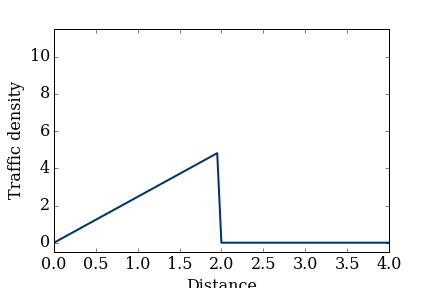
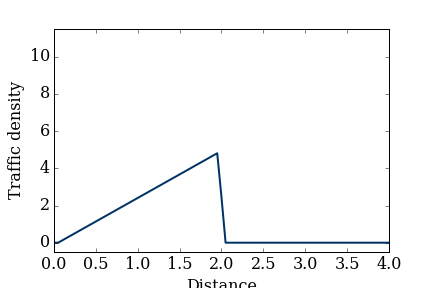
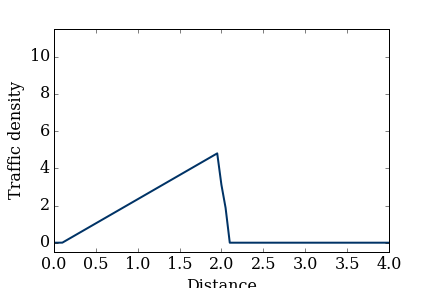
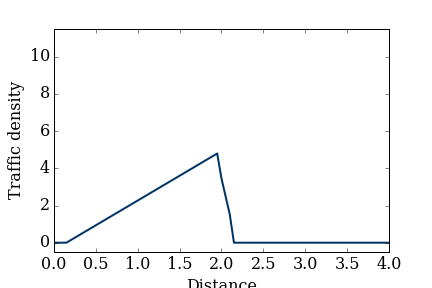
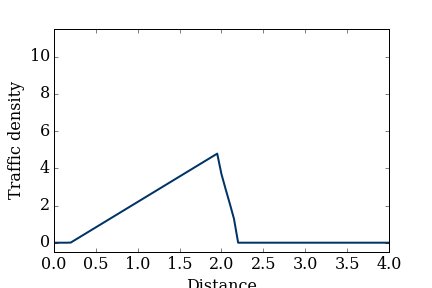
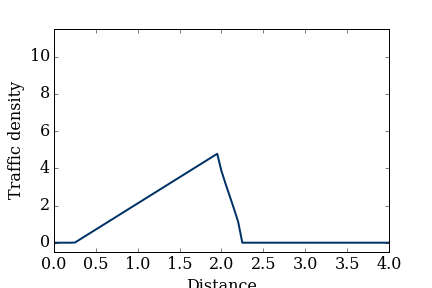
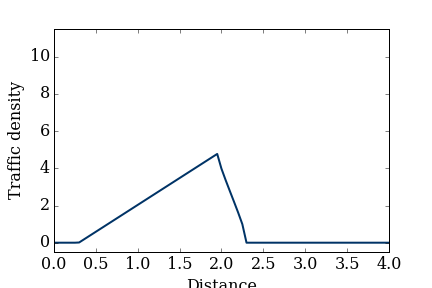
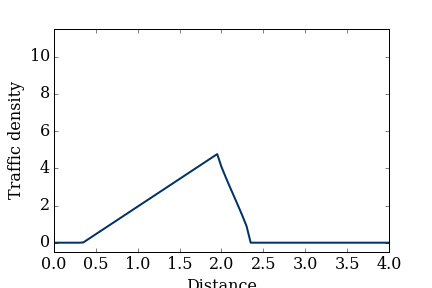
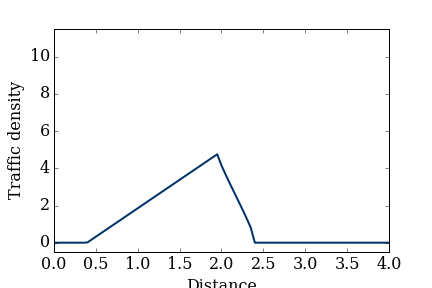
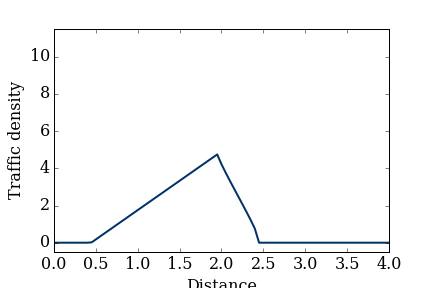
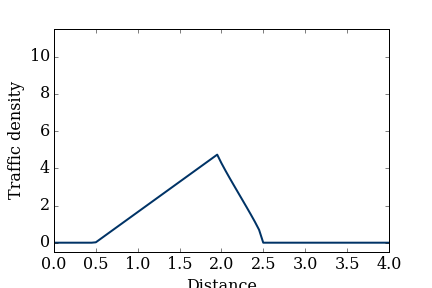
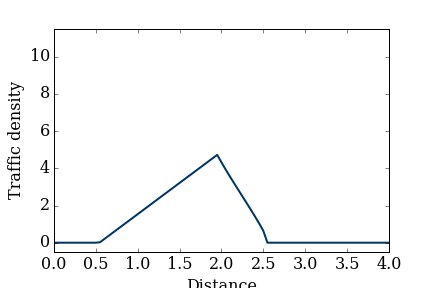
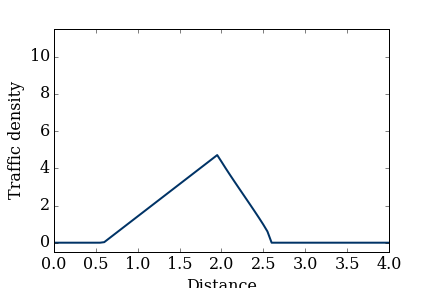
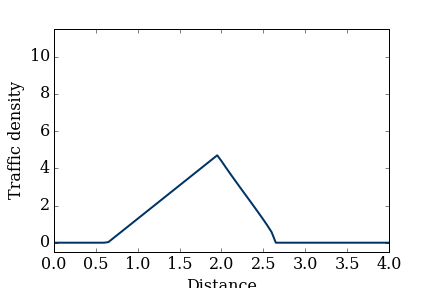
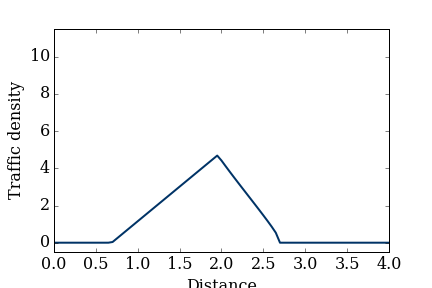
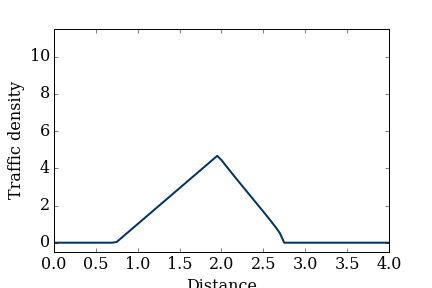
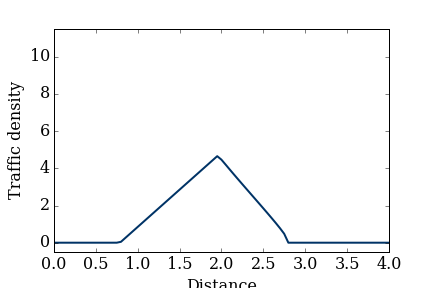
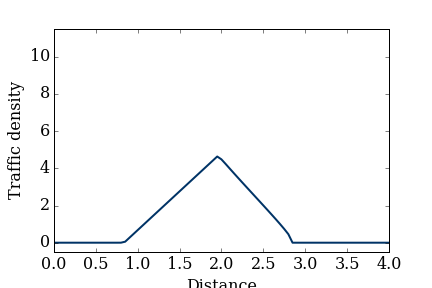
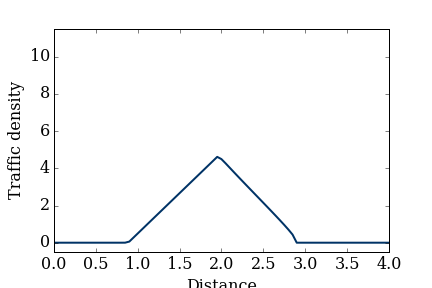
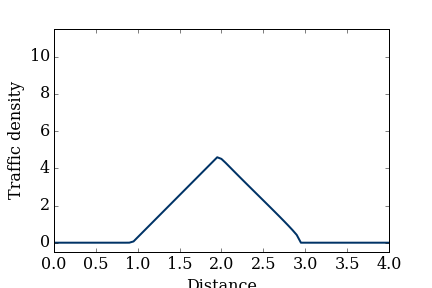
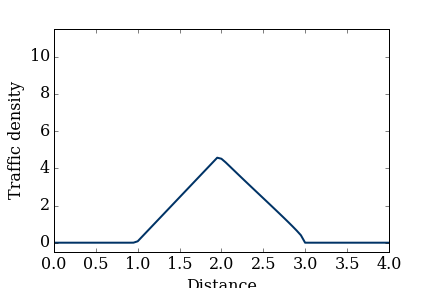
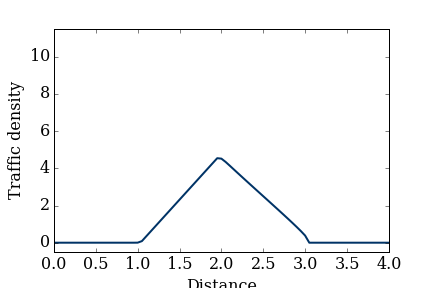
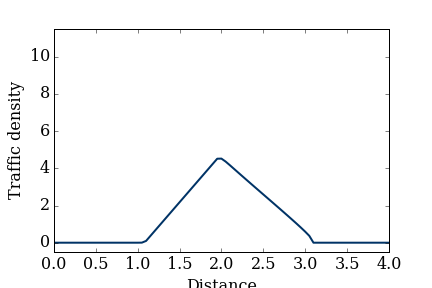
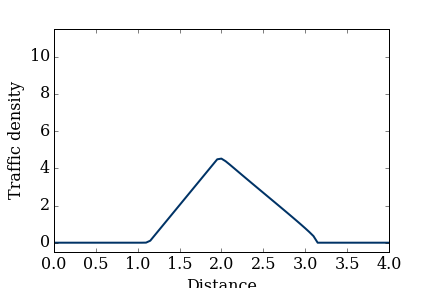
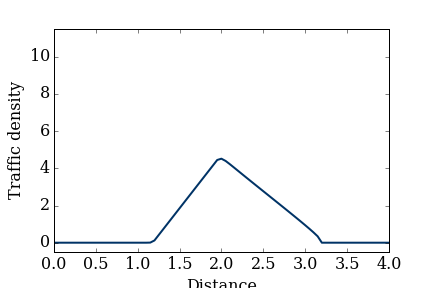
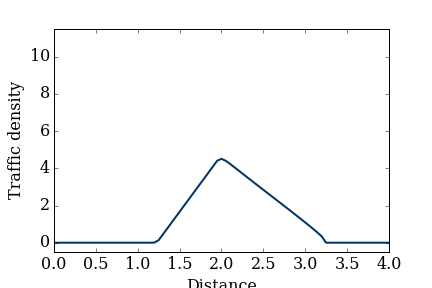
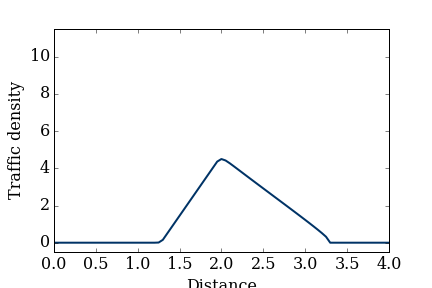
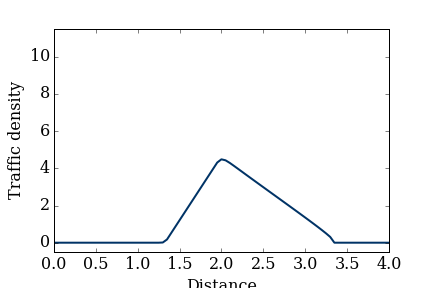
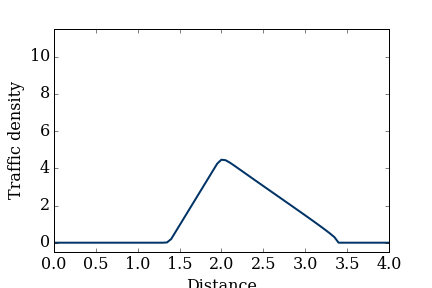
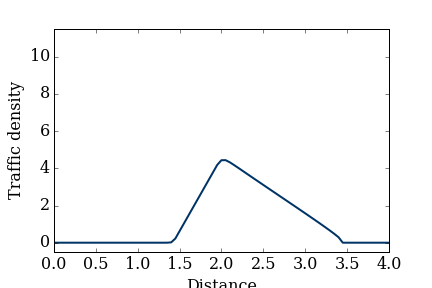
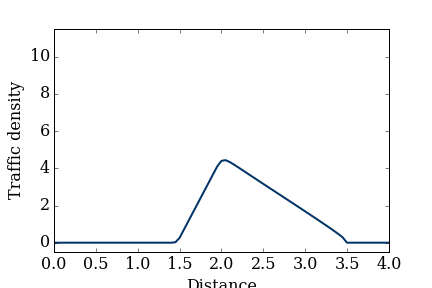
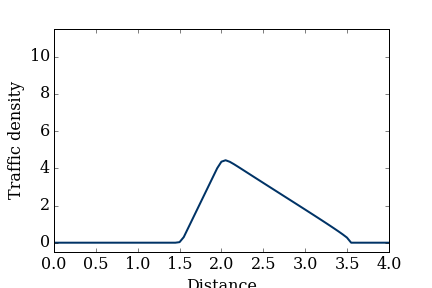
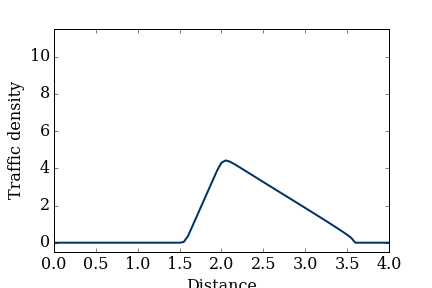
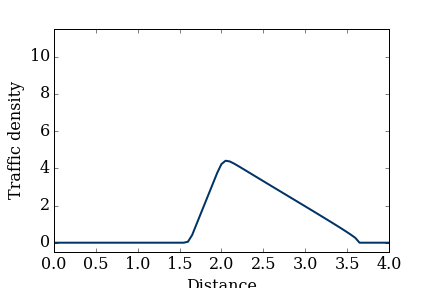
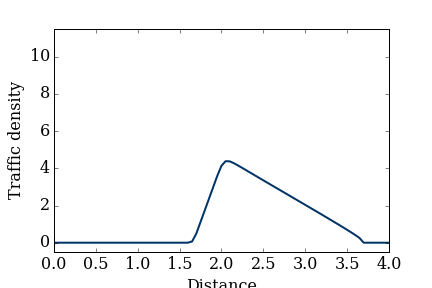
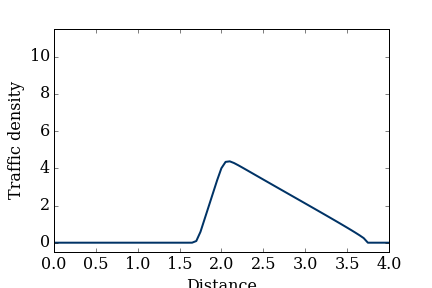
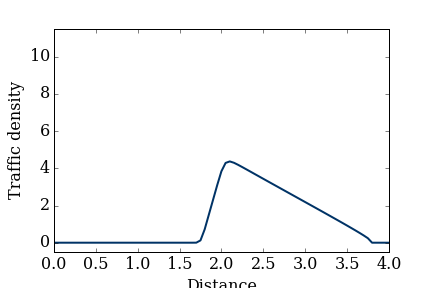
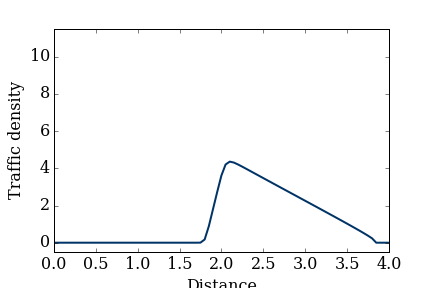
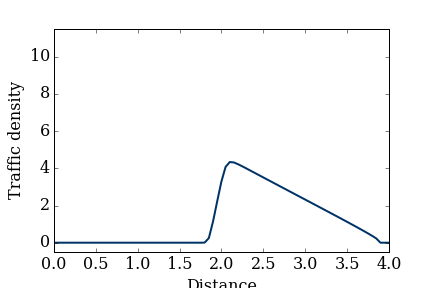
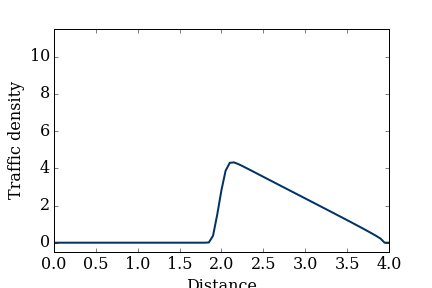

In [10]:
rho_light = 5. #5.
nt = 40
rho = rho_green_light(nx, rho_light)
rho_n = ftbs(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

Phew!  It works! Try this out yourself with different initial conditions. 

Also, you can easily create a new function `ftfs` to do a forward-time/forward-space scheme, which is stable for negative wave speeds. Unfortunately, forward in space is unstable for positive wave speeds.  If you don't want it blowing up, make sure the wave speed is negative everywhere: $u_{\rm wave} = \frac{\partial F}{\partial \rho} < 0 \ \forall \ x$.

Look at that solution again, and you'll get some nice insights of the real physical problem. See how on the trailing edge, a shock is developing? In the context of the traffic flow problem, a shock is a sign of a traffic jam: a region where traffic is heavy and slow next to a region that is free of cars. In the initial condition, the cars in the rear end of the triangle see a mostly empty road (traffic density is low!).  They see an empty road and speed up, accordingly.  The cars in the peak of the triangle are moving pretty slowly because traffic density is higher there.  Eventually the cars that started in the rear will catch up with the rest and form a traffic jam.

## Beware the CFL!

[Lesson 2 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/wave_dev/lessons/02_spacetime/02_02_CFLCondition.ipynb) discusses the CFL condition for the linear convection equation. To refresh your memory, for a constant wave speed $u_{\rm wave} = c$:

\begin{equation} \sigma = c\frac{\Delta t}{\Delta x} < 1.\end{equation}

What happens for non-linear equations? The wave speed is space- and time-dependent, $u_{\rm wave} = u_{\rm wave}(x,t)$, and the CFL condition needs to apply for every point in space, at every instant of time. We just need $\sigma>1$ in one spot, for the whole solution to blow up! 

Let's generalize the CFL condition to

\begin{equation} \sigma = \max\left[ \left| u_{\rm wave} \right| \frac{\Delta t}{\Delta x} \right] < 1.\end{equation}

which in our case is

\begin{equation} \sigma = \max\left[ u_{\rm max} \left| 1-\frac{2 \rho}{\rho_{\rm max}} \right|  \frac{\Delta t}{\Delta x} \right] < 1.\end{equation}

Here, the closer $\rho$ is to zero, the more likely it is to be unstable.

### Green light and CFL


We know that the green-light problem with density at the stop light $\rho = \rho_{\rm light} = 4$ is stable using a forward-time/backward -space scheme. Earlier, we used $u_{\rm max} = 1$, and $\Delta t/\Delta x=1$, which gives a CFL $= 1$, when $\rho = 0$. 

What if we change the conditions slightly, say $u_{\rm max} = 1.1$? 


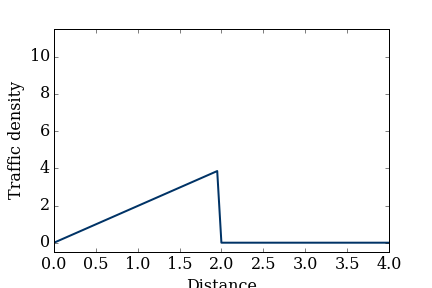
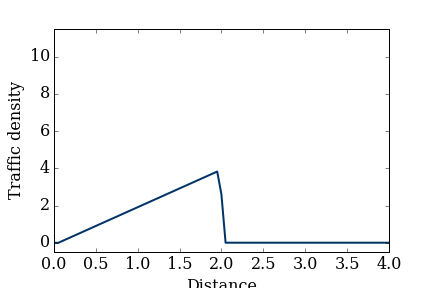
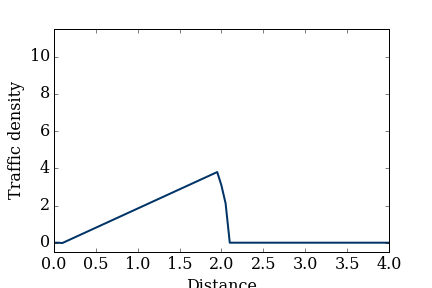
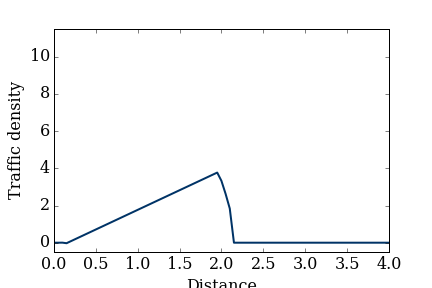
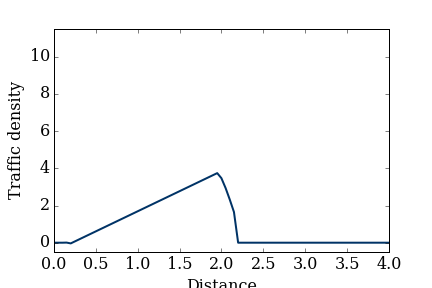
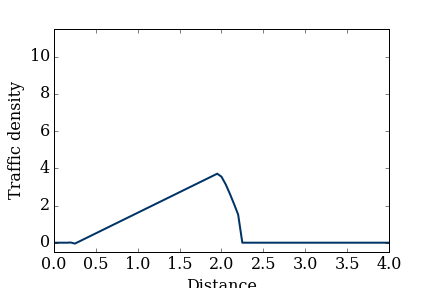
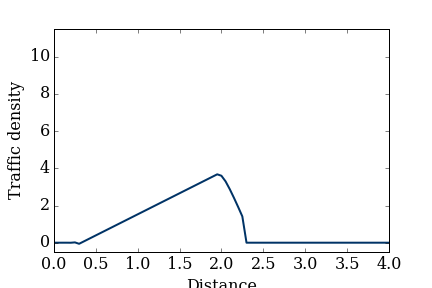
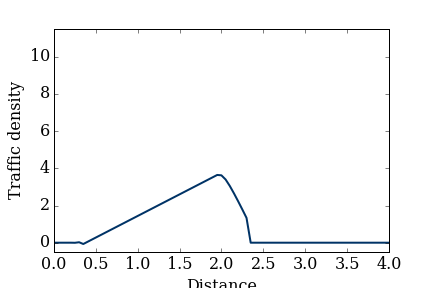
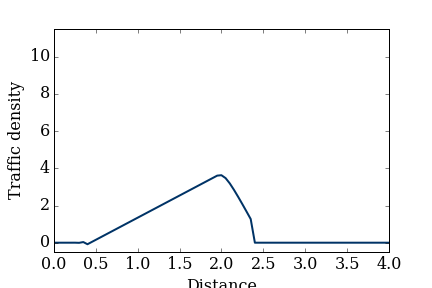
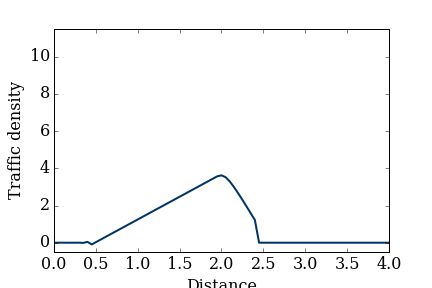
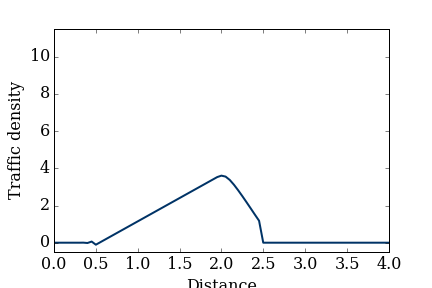
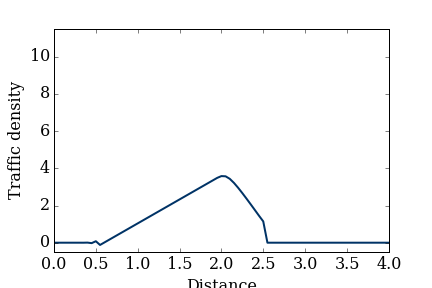
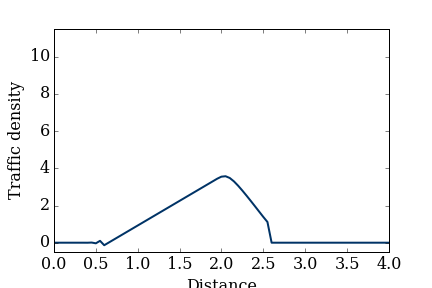
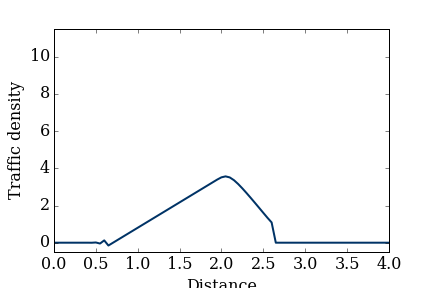
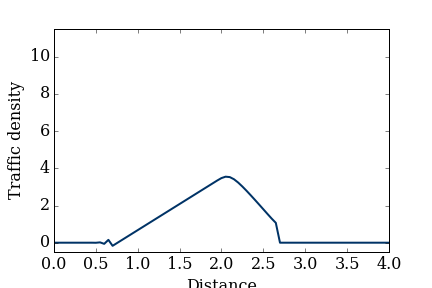
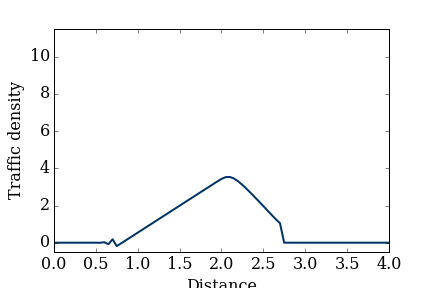
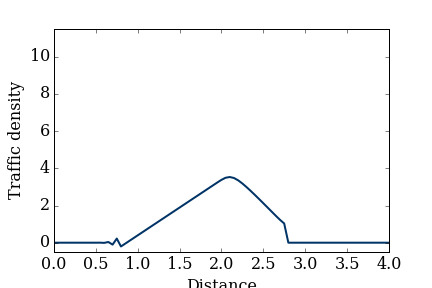
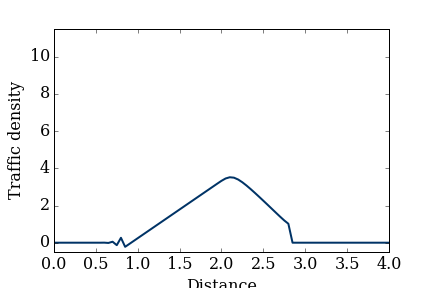
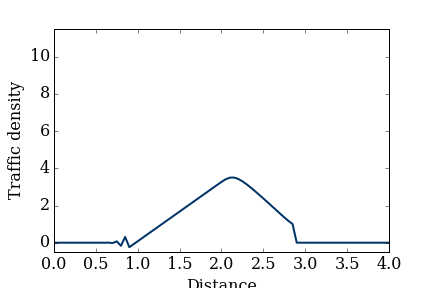
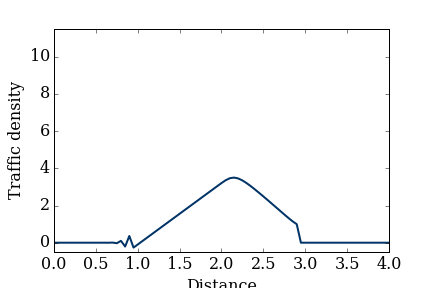
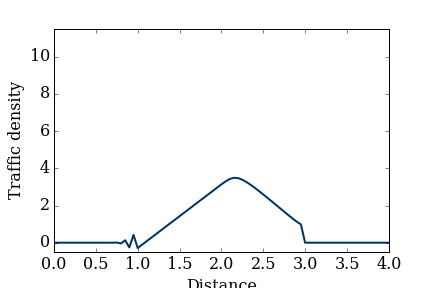
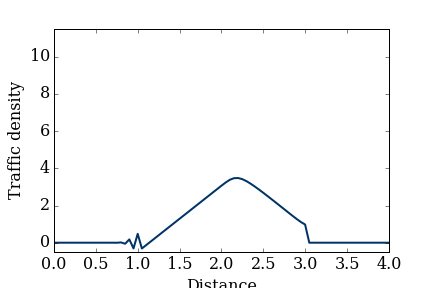
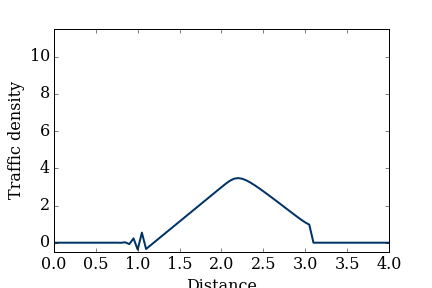
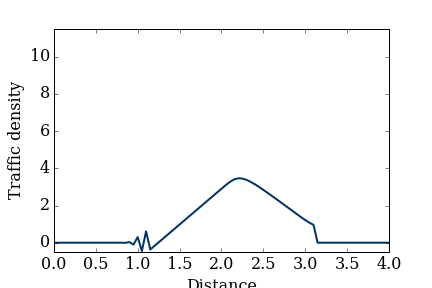
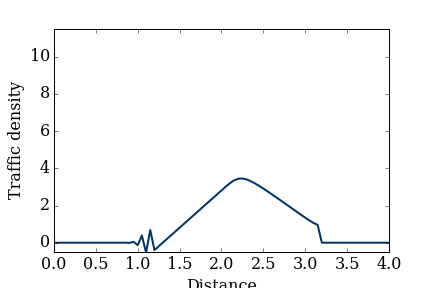
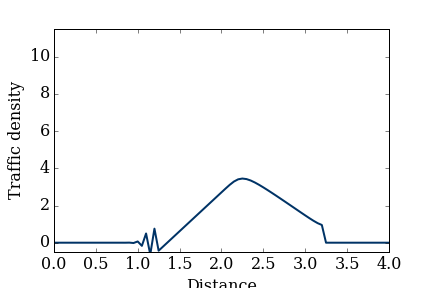
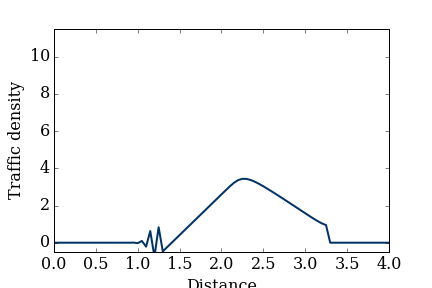
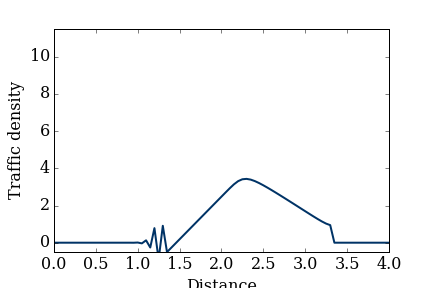
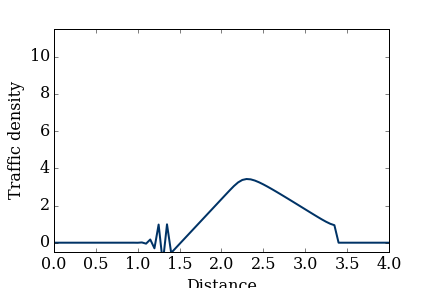
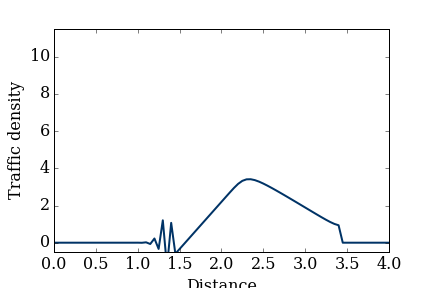
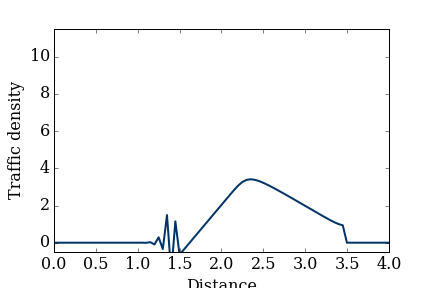
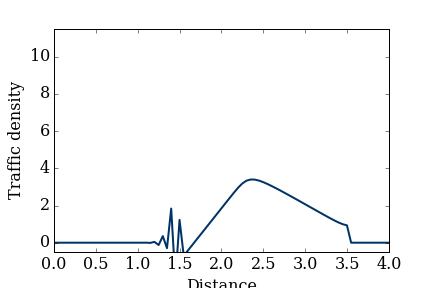
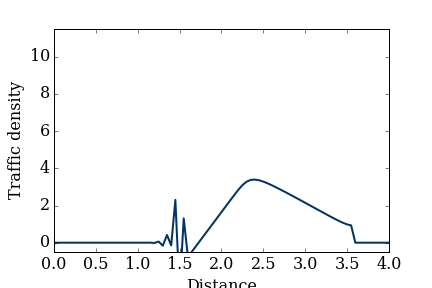
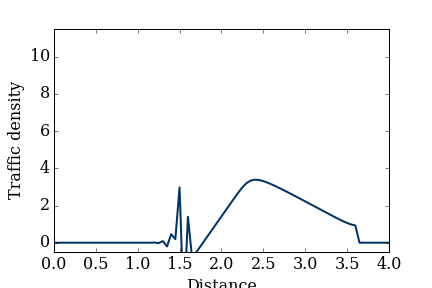
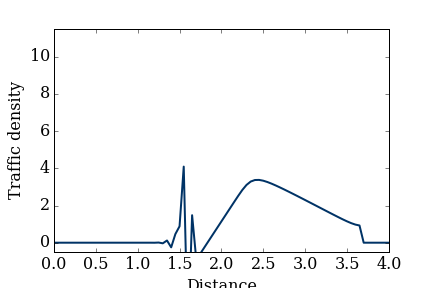
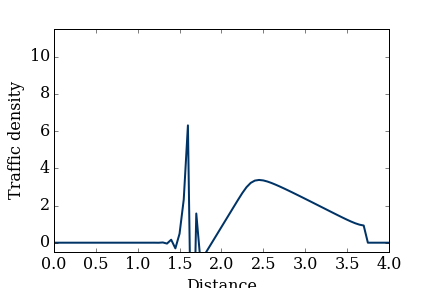
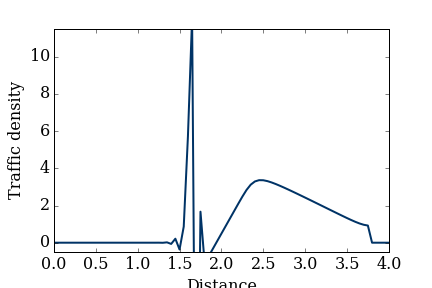
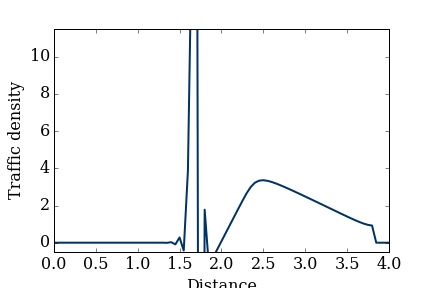
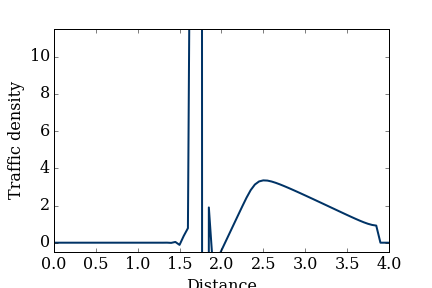
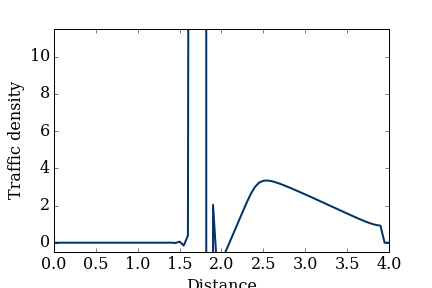

In [11]:
rho_light = 4.
u_max = 1.1
nt = 40
rho = rho_green_light(nx, rho_light)
rho_n = ftbs(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

That failed miserably! Only by changing $u_{\rm max}$ to $1.1$, even an algorithm that we know is stable for this problem, fails. Since we kept $\Delta t/\Delta x=1$, the CFL number for $\rho=0$ is $1.1$. See where the instability begins? Beware the CFL!

### Godunov

In [12]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the Godunov scheme using the Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
  
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:] # Can't do i+1/2 indices, so cell boundary
        rho_minus = rho.copy() # arrays at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + 
                      computeF(V_max, rho_max, rho_plus) + 
                      dx / dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n


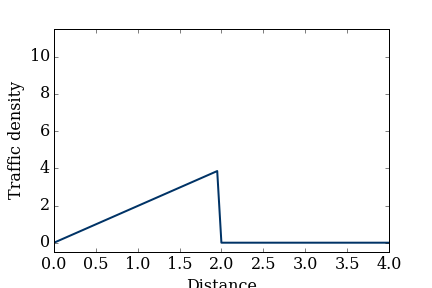
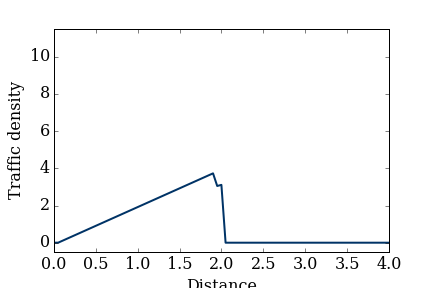
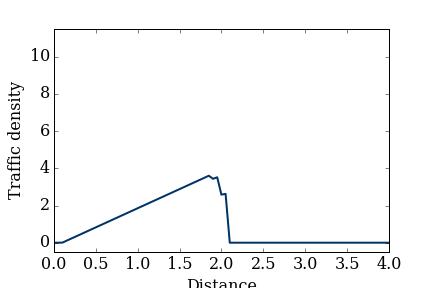
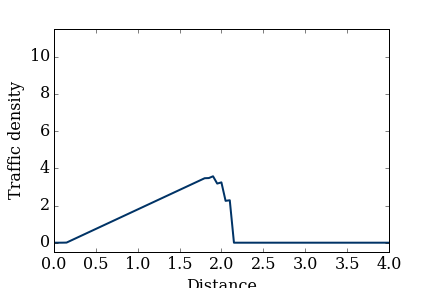
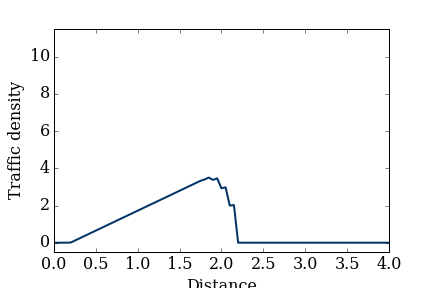
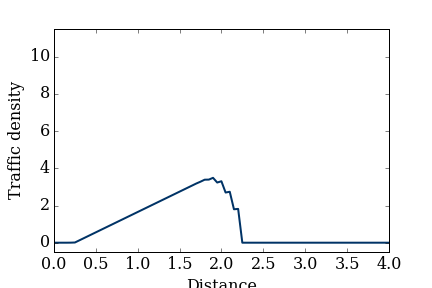
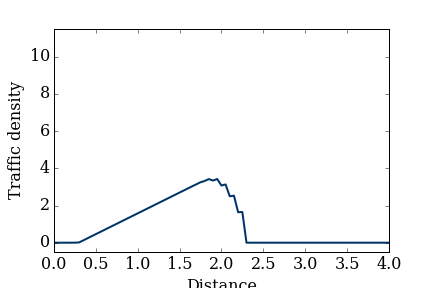
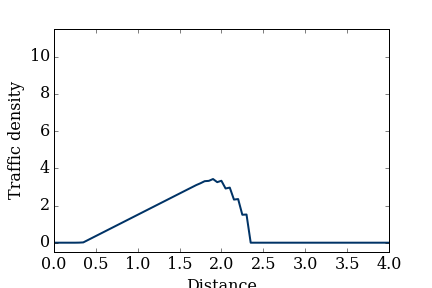
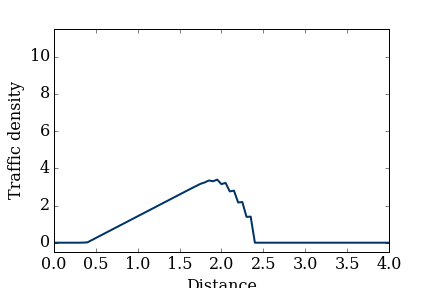
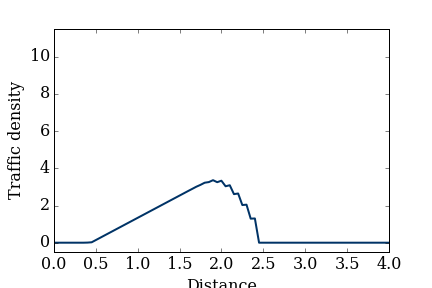
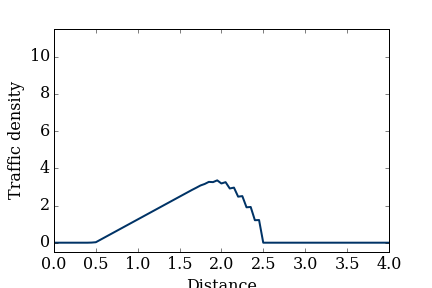
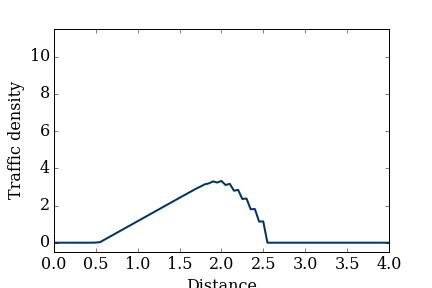
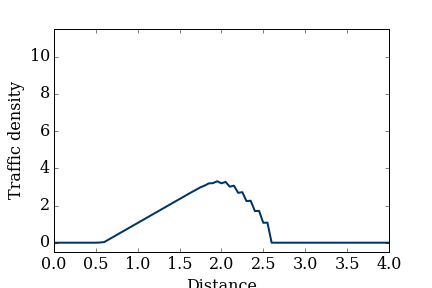
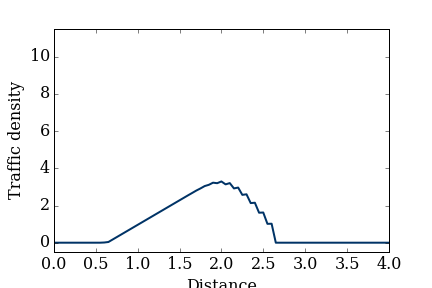
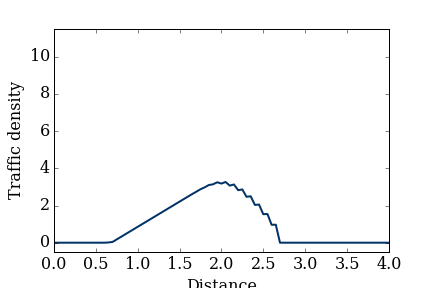
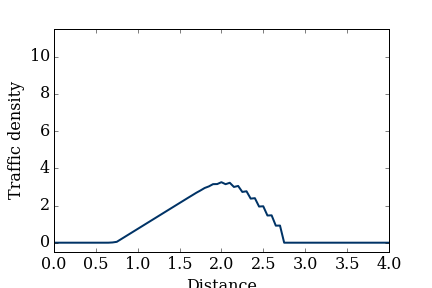
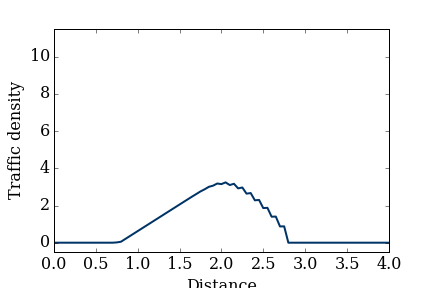
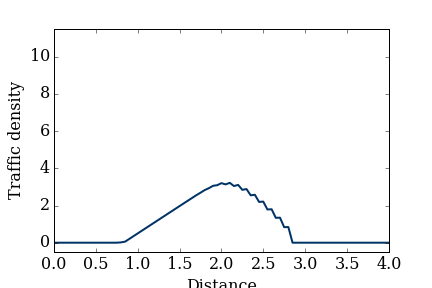
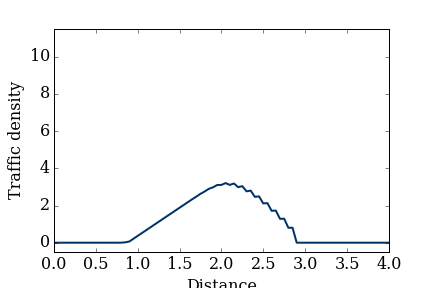
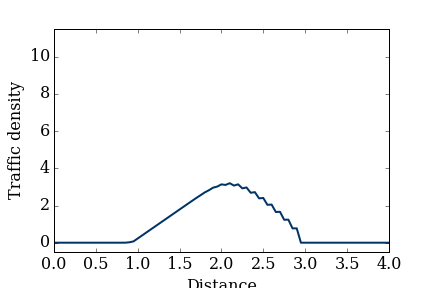
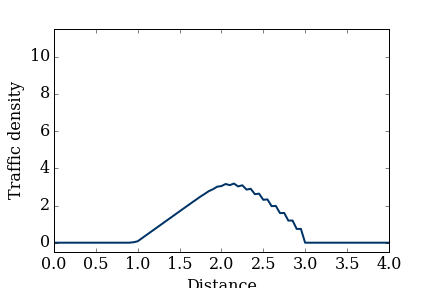
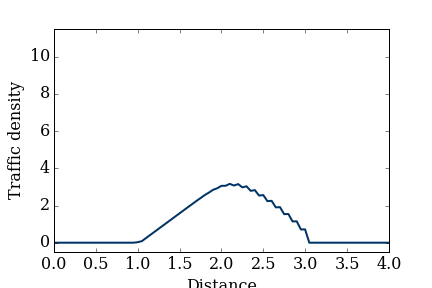
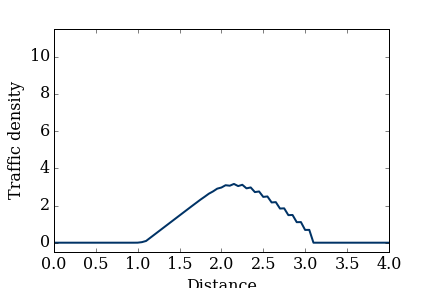
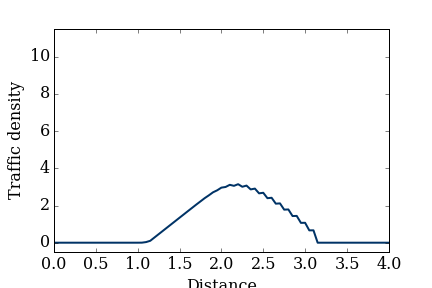
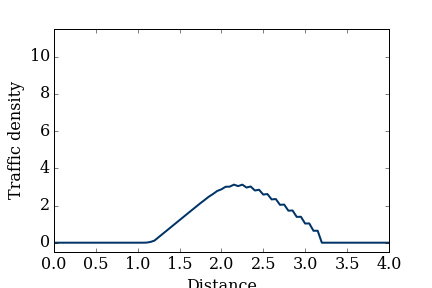
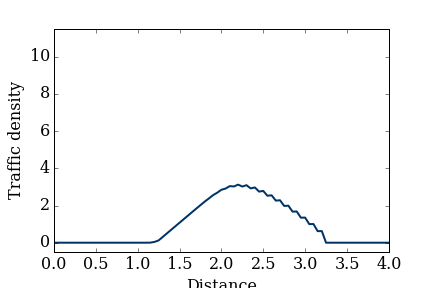
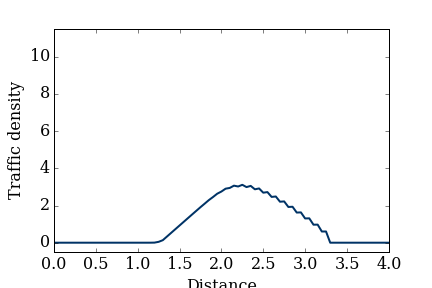
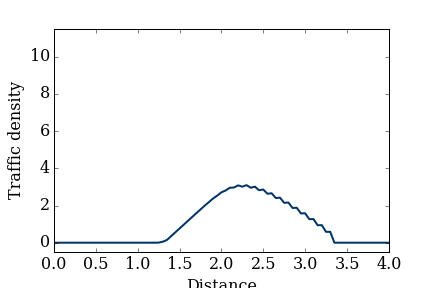
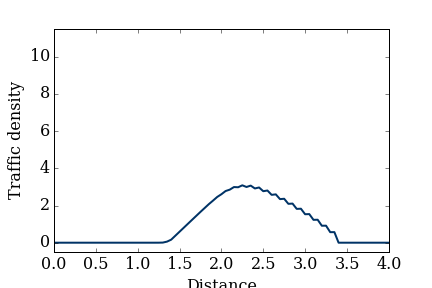
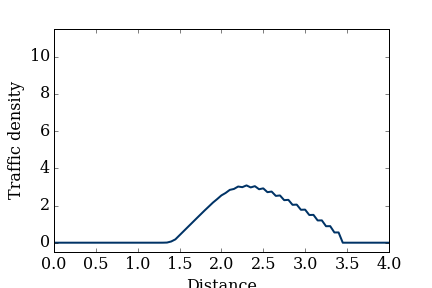
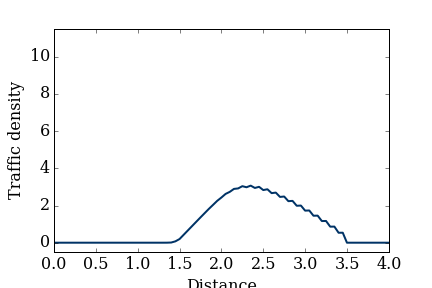
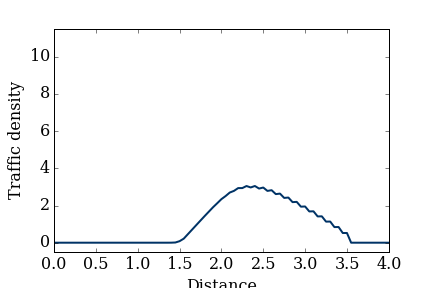
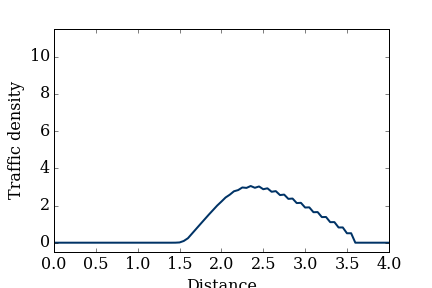
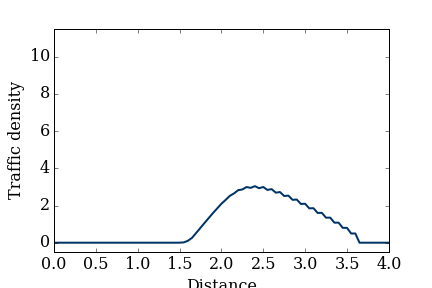
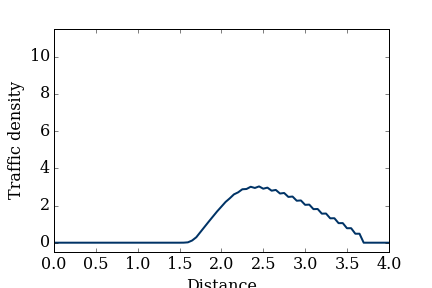
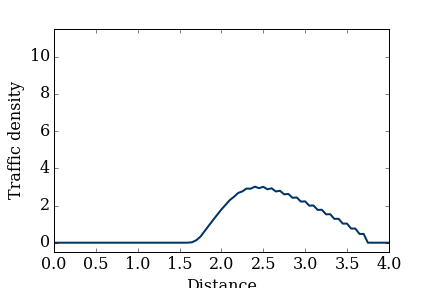
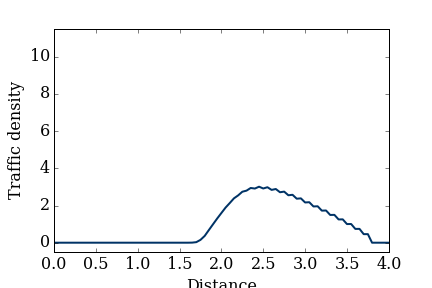
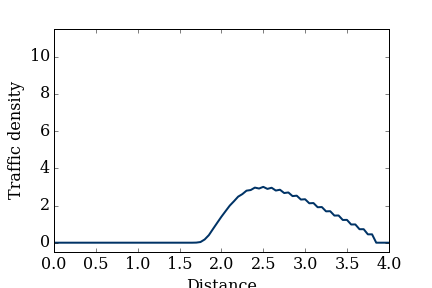
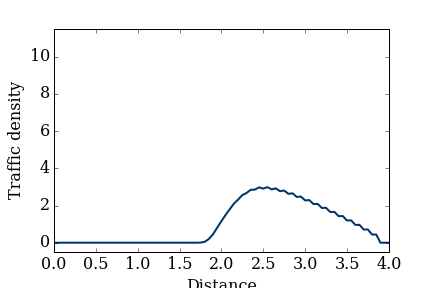
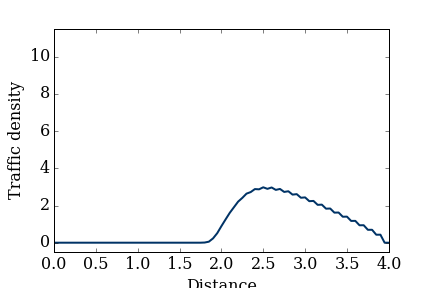

In [15]:
sigma = 1.0 #10. #0.5 #2. #1.0
dt = sigma*dx/u_max

rho = rho_green_light(nx, rho_light)
rho_n = godunov(rho, nt, dt, dx, rho_max, u_max)

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

## References

* Neville D. Fowkes and John J. Mahony, *"An Introduction to Mathematical Modelling,"* Wiley & Sons, 1994. Chapter 14: Traffic Flow.

* M. J. Lighthill and G. B. Whitham (1955), On kinematic waves. II. Theory of traffic flow and long crowded roads, _Proc. Roy. Soc. A_, Vol. 229, pp. 317–345. [PDF from amath.colorado.edu](https://amath.colorado.edu/sites/default/files/2013/09/1710796241/PRSA_Lighthill_1955.pdf), checked Oct. 14, 2014. [Original source](http://rspa.royalsocietypublishing.org/content/229/1178/317.short) on the Royal Society site.

---

###### The cell below loads the style of the notebook.

In [13]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())